# Mdm2 Gradient

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         
from os.path import dirname as parent_folde
import pandas as pd

In [2]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values, two_sided_z

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes, get_min_idx
from Bachelor_ExternalFunctions import analyze_slips

In [3]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = True

In [4]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

In [5]:
# Getting the data and converting to numpy array: 

dataframe_m = pd.read_csv('Data/mdata.csv', header=None, index_col=None)
dataframe_p = pd.read_csv('Data/pdata.csv', header=None, index_col=None)

dataframe_m = dataframe_m.to_numpy()
dataframe_p = dataframe_p.to_numpy()

In [6]:
# Identifying and saving the traces, where the concentration gets very small. 

removed_traces_m = []
removed_idx = [] 
removed_traces_p = []

for i in range(0, 422): 
    for j in range(49, 287):  # Ocsillation should begin after the 49th datapoint. 
        if dataframe_m[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            
        if dataframe_p[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            break

In [7]:
# Cleaning the dataframes for traces:  

data_m = np.delete(dataframe_m, removed_idx, 0)
data_p = np.delete(dataframe_p, removed_idx, 0)

In [8]:
# Finding the average fluctuations before oscillations to use as a baseline/initial error for fitting

fluct_m = [(np.std(data_m[i][:49], ddof=1)) for i in range(len(data_m))]  
fluct_p = [(np.std(data_p[i][:49], ddof=1)) for i in range(len(data_p))]

avefluct_m = np.mean(fluct_m)  # Maybe use mode/median instead
avefluct_p = np.mean(fluct_p)

sigma_avefluct_m = np.std(fluct_m, ddof=1) / np.sqrt(len(fluct_m))

print(f'The mean fluctuations before oscillations: {avefluct_m:.2f}(mdm2) and {avefluct_p:.2f}(p53)')

The mean fluctuations before oscillations: 9.34(mdm2) and 22.37(p53)


In [9]:
logdata_m = [np.log(i[49:]) for i in data_m]
logdata_p = [np.log(i[49:]) for i in data_p]

In [10]:
# Removing noise by fitting a fourth order polynomium: 

def remove_noise(x, p0, p1, p2, p3, p4): 
    return p0 + p1*x + p2*x**2 + p3*x**3 + p4*x**4

time = np.linspace(0, 287/2, 287)
t = time[49:]

# Calculation the residuals for all of the data series: 

resi_m = []
resi_p = []

for i in range(len(data_m)): 
    
    fit_obj_m = Chi2Regression(remove_noise, t, data_m[i][49:], avefluct_m)
    fit_obj_p = Chi2Regression(remove_noise, t, data_p[i][49:], avefluct_p)

    minuit_m = Minuit(fit_obj_m, 30, 1, 1, 1, 1)
    minuit_p = Minuit(fit_obj_p, 30, 1, 1, 1, 1)
    
    minuit_m.errordef = 1.0  
    minuit_p.errordef = 1.0 

    minuit_m.migrad() 
    minuit_p.migrad()
    
    resi_m.append(data_m[i][49:] - remove_noise(t, *minuit_m.values[:]))
    resi_p.append(data_p[i][49:] - remove_noise(t, *minuit_p.values[:]))
    
print(f'The mean of the p53 and Mdm2 residuals: {np.mean(resi_p):.5f} and {np.mean(resi_m):.6f}')

The mean of the p53 and Mdm2 residuals: -0.00015 and -0.000031


In [11]:
# Removing noise from logdata by fitting a fourth order polynomium: 

def remove_noise(x, p0, p1, p2, p3, p4): 
    return p0 + p1*x + p2*x**2 + p3*x**3 + p4*x**4

time = np.linspace(0, 287/2, 287)
t = time[49:]

# Calculation the residuals for all of the data series: 

logresi_m = []
logresi_p = []

for i in range(len(data_m)): 
    
    fit_obj_m = Chi2Regression(remove_noise, t, logdata_m[i], avefluct_m)
    fit_obj_p = Chi2Regression(remove_noise, t, logdata_p[i], avefluct_p)

    minuit_m = Minuit(fit_obj_m, 30, 1, 1, 1, 1)
    minuit_p = Minuit(fit_obj_p, 30, 1, 1, 1, 1)
    
    minuit_m.errordef = 1.0  
    minuit_p.errordef = 1.0 

    minuit_m.migrad() 
    minuit_p.migrad()
    
    logresi_m.append(logdata_m[i] - remove_noise(t, *minuit_m.values[:]))
    logresi_p.append(logdata_p[i] - remove_noise(t, *minuit_p.values[:]))
    
print(f'The mean of the p53 and Mdm2 residuals: {np.mean(logresi_p):.5f} and {np.mean(logresi_m):.6f}')

The mean of the p53 and Mdm2 residuals: -0.00007 and -0.000010


In [12]:
# Shifting all log mdm2 traces three places: 

roll_logresi_m = np.zeros(shape=(402, 238))

for i in range(len(logresi_m)): 
    roll_logresi_m[i] = np.roll(logresi_m[i], -3)
    
    
# Shifting all normal mdm2 traces three places: 

roll_resi_m = np.zeros(shape=(402, 238))

for i in range(len(resi_m)): 
    roll_resi_m[i] = np.roll(resi_m[i], -3)

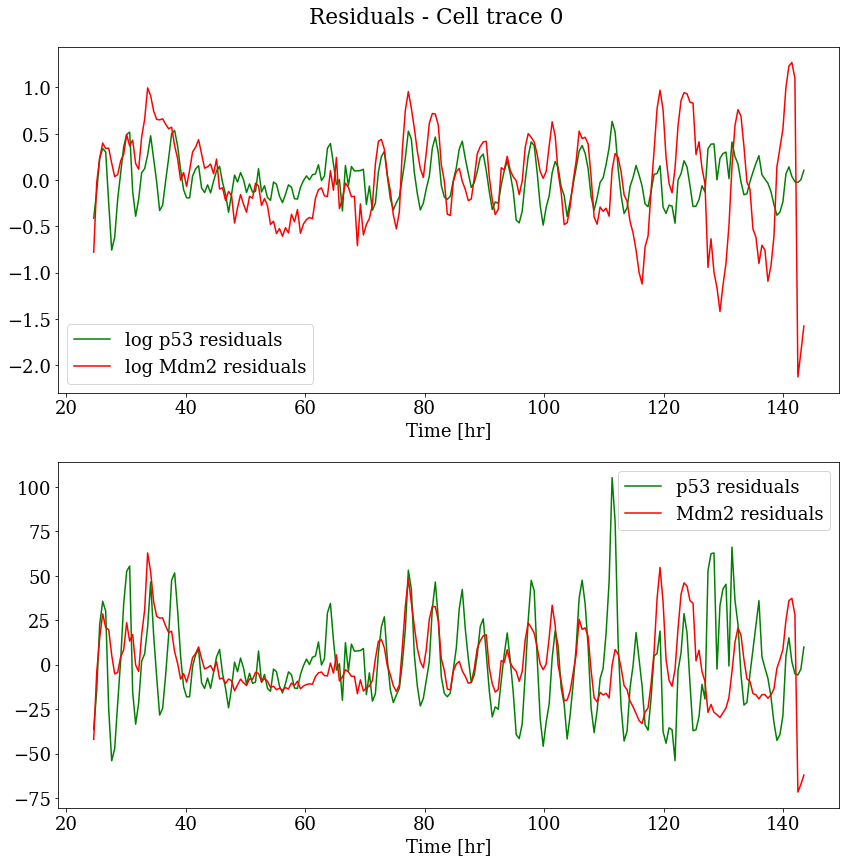

In [13]:
# Plotting the first traces for p53 and mdm2 in normal and log space: 

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
fig.suptitle('Residuals - Cell trace 0', y=0.92)
ax1.plot(t, logresi_p[0], color='green', label='log p53 residuals')
ax1.plot(t, roll_logresi_m[0], color='red', label='log Mdm2 residuals')
ax1.set(xlabel='Time [hr]')
ax1.legend()

ax2.plot(t, resi_p[0], color='green', label='p53 residuals')
ax2.plot(t, roll_resi_m[0], color='red', label='Mdm2 residuals')
ax2.set(xlabel='Time [hr]')
ax2.legend()

if save_plots: 
    fig.savefig(r'Graphs/LOGResiduals.png');

In [14]:
def gradient_skips(data_p, data_m, peaks_p, local_min_p, ax=None): 
    
    local_min_p_idx = get_min_idx(data_p, local_min_p)  # Getting indices for local minima
    
    
    gradient_m = np.gradient(data_m)                    # Calculating the gradient for all mdm2 data
    norm_gradient_m = gradient_m / max(np.abs(gradient_m))      # Normalizing the values 
    
    
    # Getting all the peak areas: 
    
    peak_times = [t[:local_min_p_idx[0]+1]]              
    peak_areas_p = [data_p[:local_min_p_idx[0]+1]]
    peak_areas_m = [data_m[:local_min_p_idx[0]+1]]
    peak_areas_grad =[gradient_m[:local_min_p_idx[0]+1]]
    peak_areas_normgrad =[norm_gradient_m[:local_min_p_idx[0]+1]]
    
    for i in range(1, len(local_min_p_idx)):
        peak_times.append(t[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_p.append(data_p[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_m.append(data_m[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_grad.append(gradient_m[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_normgrad.append(norm_gradient_m[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        
    peak_times.append(t[local_min_p_idx[-1]:])
    peak_areas_p.append(data_p[local_min_p_idx[-1]:])
    peak_areas_m.append(data_m[local_min_p_idx[-1]:])
    peak_areas_grad.append(gradient_m[local_min_p_idx[-1]:])
    peak_areas_normgrad.append(norm_gradient_m[local_min_p_idx[-1]:])

    
    skips_idx = []
    
    for i in range(len(peak_areas_grad)): 
        if all(peak_areas_grad[i][j] <= 0 for j in range(0, len(peak_areas_grad[i]))): 
            skips_idx.append(i)
            
    
    if ax: 
        ax.plot(t, data_p, color='green', label='p53')
        ax.plot(t, data_m, color='red', label='mdm2')
        ax.set(ylabel='Concentration', 
               xlim=(t[0]-1, t[-1]+1))
        ax.legend()
        for i in local_min_p_idx: 
            ax.vlines(t[i], min([min(data_p), min(data_m)]), 
                      max([max(data_p), max(data_m)]), linestyle='dashed', color='grey')
            
        for i in skips_idx:
            ax.plot(t[peaks_p[i]], data_p[peaks_p[i]], 'x', ms=8, mew=2, color='purple')
    
    return peak_times, peak_areas_p, peak_areas_m, peak_areas_normgrad, norm_gradient_m, skips_idx, peak_areas_grad

In [15]:
# Finding the peaks and local minima in all p53 traces:  
# These arrays are used to check for a negative/zero gradient in all of the p53 peak areas

all_peaks_p = []          # Index for peaks. Len 402
all_local_min_p = []      # Value of min before the peak. 

all_peaks_m = [] 
all_local_min_m = []

all_peak_times = []       # Areas around peaks 
all_peak_areas_p = []
all_peak_areas_m = [] 
all_peak_areas_grad = []
all_peak_areas_normgrad = []  # Gradient in each p53 peak area

all_gradients = []        # All gradients along a trace for mdm2 
all_skips = []            # Index of area, where the gradients are negative/zero

mdm2_slips = []          # p53 indices of skips from comparison of peaks 


for i in range(len(resi_p)): 
    
    peaks_p, min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    peaks_m, min_m = peak_finder(roll_resi_m[i], N_peaks='low', threshold=avefluct_m)
    
    all_peaks_p.append(peaks_p)   
    all_local_min_p.append(min_p)
    all_peaks_m.append(peaks_m)   
    all_local_min_m.append(min_m)
    
    (peak_times, peak_areas_p, peak_areas_m, 
     peak_areas_normgrad, normgradient, skips, peak_areas_grad) = gradient_skips(resi_p[i], roll_resi_m[i], 
                                                               peaks_p, min_p, ax=None)
    all_peak_times.append(peak_times)
    all_peak_areas_p.append(peak_areas_p)
    all_peak_areas_m.append(peak_areas_m)
    all_peak_areas_grad.append(peak_areas_grad)
    all_peak_areas_normgrad.append(peak_areas_normgrad)
    all_gradients.append(normgradient)
    all_skips.append(skips) 
    
    slips = compare_peaks(peaks_p, peaks_m, min_p)[1]
    mdm2_slips.append(slips)

In [16]:
# Counting number of skips from Gradient Method

count_areas_neggrad = 0 
count_peaks = 0 

for i in all_peak_areas_grad:
    count_peaks += len(i) 
    for j in range(len(i)): 
        if 0 >= np.max(i[j]):   # if 0 >= np.max(i[j][:-1]): 
            count_areas_neggrad += 1
            
print(f'The number of areas with zero or negative gradient: {count_areas_neggrad}')
print(f'Average number of skips in a trace: {count_areas_neggrad/len(resi_p):1.2f}')
print(f'Percent of peaks with skips: {count_areas_neggrad / count_peaks * 100:1.2f}%')

The number of areas with zero or negative gradient: 426
Average number of skips in a trace: 1.06
Percent of peaks with skips: 3.51%


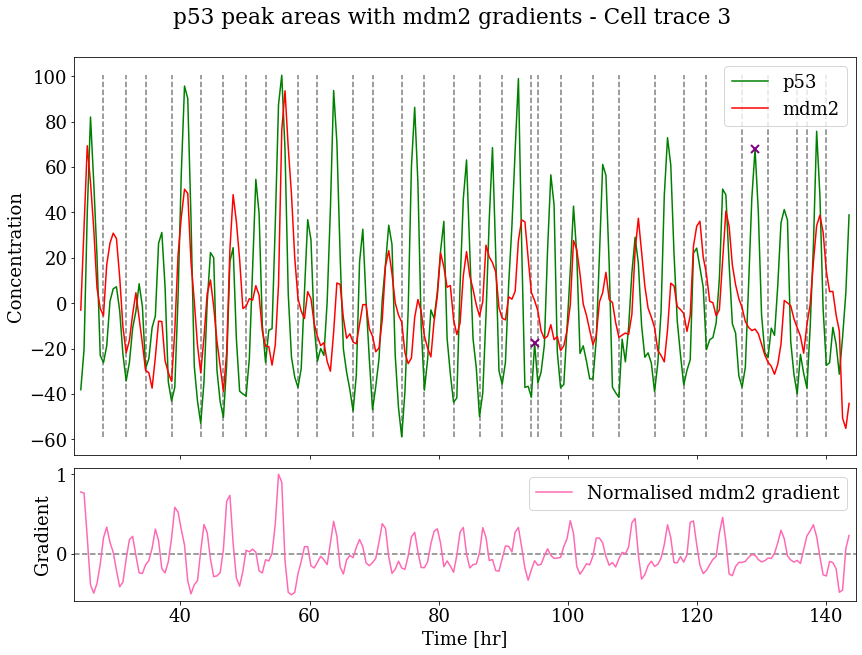

In [17]:
# Plotting for the first cell trace with skips:
trace_idx = 3

fig, axs = plt.subplots(2, 1, figsize=(14,10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
suptitle = fig.suptitle(f'p53 peak areas with mdm2 gradients - Cell trace {trace_idx}', y=0.95)

# Plotting the gradients: 
gradient_skips(resi_p[trace_idx], roll_resi_m[trace_idx], all_peaks_p[trace_idx], all_local_min_p[trace_idx], axs[0])

axs[1].plot(t, all_gradients[trace_idx]/max(all_gradients[trace_idx]), color='hotpink', label='Normalised mdm2 gradient')

axs[1].hlines(0, t[0]-1, t[-1]+1, linestyle='dashed', color='grey')
axs[1].set(xlabel='Time [hr]', 
           ylabel='Gradient')
axs[1].legend()

fig.subplots_adjust(hspace=0.05)

if save_plots: 
    plt.savefig(r'Graphs/PeakAreasGradient0.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

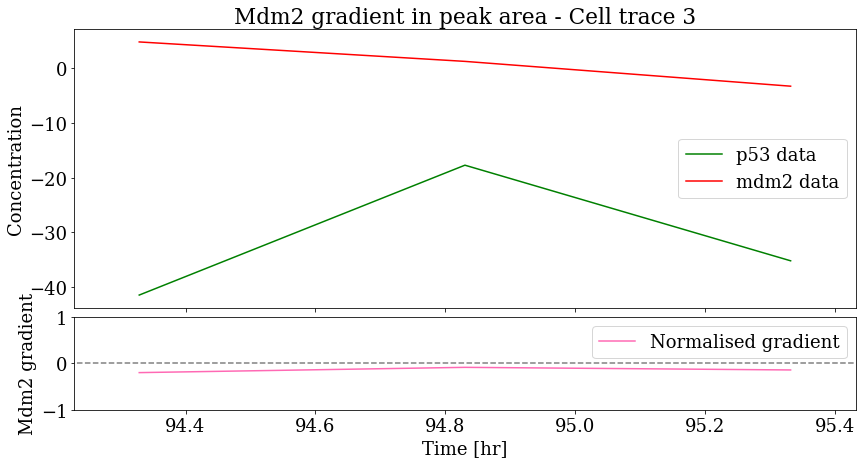

In [18]:
# Looking closer into areas with negative/zero gradient: 

area_idx = all_skips[trace_idx][0]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(all_peak_times[trace_idx][area_idx], all_peak_areas_p[trace_idx][area_idx], color='green', label='p53 data')
axs[0].plot(all_peak_times[trace_idx][area_idx], all_peak_areas_m[trace_idx][area_idx], color='red', label='mdm2 data')

axs[0].set(ylabel='Concentration', 
           title=f'Mdm2 gradient in peak area - Cell trace {trace_idx}',
           xlim=(all_peak_times[trace_idx][area_idx][0]-0.1, all_peak_times[trace_idx][area_idx][-1]+0.1))

axs[0].legend()


axs[1].plot(all_peak_times[trace_idx][area_idx], all_peak_areas_normgrad[trace_idx][area_idx], 
            color='hotpink', label='Normalised gradient')

axs[1].set(xlabel='Time [hr]',
           ylabel='Mdm2 gradient',
           ylim=(-1, 1))

axs[1].hlines(0, 20, 150, linestyle='dashed', color='grey')
axs[1].legend()

fig.subplots_adjust(hspace=0.05)

if save_plots: 
    plt.savefig(r'Graphs/NegGradient3.png');

In [19]:
# Finding the maximum gradient in all p53 peak areas for a histogram: 
max_gradients = [] 
p53_at_max_grad = [] 

for i in range(len(all_peak_areas_grad)): 
    for j in range(len(all_peak_areas_grad[i])):
        max_gradients.append(np.max(all_peak_areas_grad[i][j]))
        p53_at_max_grad.append(all_peak_areas_p[i][j][np.argmax(all_peak_areas_grad[i][j])])

In [20]:
# Fitting the tail of the historgram with exp-func: 

x, y, sy = zerobin_hist(max_gradients, bins=100, xmin=-15, xmax=110);

binwidth = x[1] - x[0]

def exp_func(x, N, loc, scale):
    return N * binwidth * stats.expon.pdf(x, loc, scale)

fit_obj = Chi2Regression(exp_func, x[x > 11], y[x > 11], sy[x > 11])

minuit = Minuit(fit_obj, N=sum(y[x > 11]), loc=12, scale=40)       
minuit.errordef = 1.0     
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 124.2                      │              Nfcn = 236              │
│ EDM = 1.83e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │   6.1e3   │   1.2e3   │            │            │         │         │       │
│ 1 │ loc   │   11.9    │    2.5    │            │            │         │         │       │
│ 2 │ scale │   12.54   │   0.14    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         N       loc     scale │
├───────┼───────────────────────────────┤
│     N │  1.44e+06 -2.98e+03     0.127 │
│   loc │ -2.98e+03      6.17  0.000931 │
│ scale │     0.127  0.000931    0.0206 │
└───────┴───────────────────────────────┘

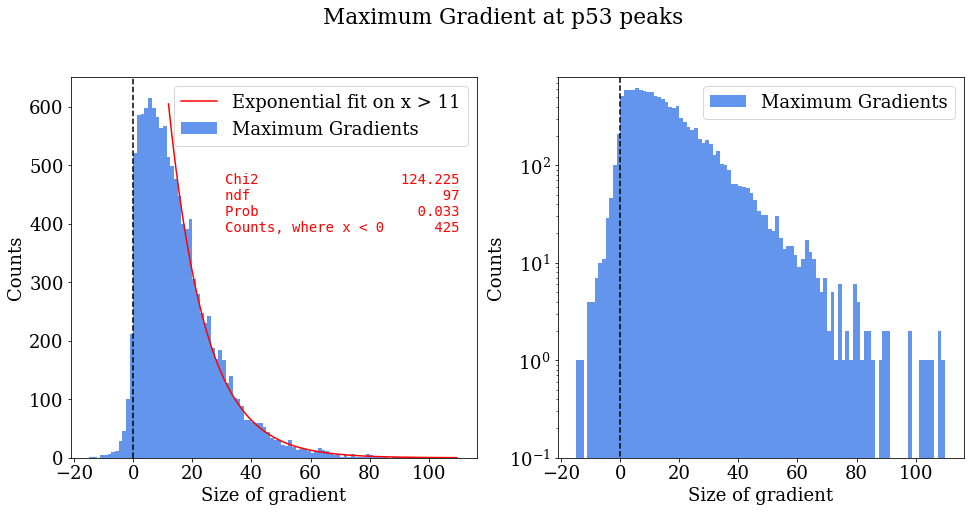

In [21]:
# Plotting: 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
suptitle = fig.suptitle('Maximum Gradient at p53 peaks', y=1.02)

ax1.hist(max_gradients, bins=100, range=(-15, 110), color='cornflowerblue', label='Maximum Gradients') #, log=True)

ax1.plot(x[x > 11], exp_func(x[x > 11], *minuit.values[:]), color='red', label='Exponential fit on x > 11')

ax1.legend()

# Adding fit results to plot:
d = {'Chi2':     minuit.fval,
     'ndf':      100 - minuit.nfit,
     'Prob':     stats.chi2.sf(minuit.fval, 100 - minuit.nfit),
     'Counts, where x < 0':    sum(y[x < 0])
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.38, 0.75, text, ax1, fontsize=14, color='red')


ax1.vlines(0, 0, 650, linestyle='dashed')
ax1.set(ylim=(0, 650), 
       xlabel='Size of gradient', 
       ylabel='Counts')

ax2.hist(max_gradients, bins=100, range=(-15, 110), color='cornflowerblue', label='Maximum Gradients') #, log=True)
ax2.set(xlabel='Size of gradient', 
        ylabel='Counts', 
        yscale='log')

ax2.vlines(0, 0, 800, linestyle='dashed')
ax2.set(ylim=(0.1, 800))
ax2.legend()


if save_plots: 
    fig.savefig(r'Graphs/MaxGradAtPeaks.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [27]:
# Fitting the log-distribution with segments of linear lines: 

def boundary_fit(x, a, b, p0, p1, p2): 
    if x < a: 
        return p1 * x + p0
    
    elif a <= x < b: 
        return p1 * a + p0
    
    else: 
        return p1 * a + p0 + p2 * (x - b)  

In [23]:
# Performing the fit: 
 
fit_obj_log = Chi2Regression(boundary_fit, x, np.log(y), np.log(sy+1))

minuit_log = Minuit(fit_obj_log, a=0, b=13, p0=6.25, p1=0.45, p2=-0.07)   
minuit_log.limits['a'] = (0.1, 2)          # Limiting parameters
minuit_log.limits['b'] = (10, 15)
minuit_log.limits['p0'] = (6.3, 7)
minuit_log.limits['p1'] = (0.30, 0.60)
minuit_log.limits['p2'] = (-0.1, -0.05)
minuit_log.errordef = 1.0     
minuit_log.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.54                      │              Nfcn = 127              │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.10    │   0.24    │            │            │   0.1   │    2    │       │
│ 1 │ b    │   10.0    │    3.2    │            │            │   10    │   15    │       │
│ 2 │ p0   │   6.30    │   0.08    │            │            │   6.3   │    7    │       │
│ 3 │ p1   │   0.473   │   0.031   │            │            │   0.3   │   0.6   │       │
│ 4 │ p2   │  -0.0745  │  0.0020   │            │            │  -0.1   │  -0.05  │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │         a         b        p0        p1        p2 │
├────┼───────────────────────────────────────────────────┤
│  a │  9.46e-08 -1.24e-12 -3.05e-14 -1.37e-09 -1.98e-09 │
│  b │ -1.24e-12  8.17e-06 -2.81e-13 -7.91e-10 -2.05e-08 │
│ p0 │ -3.05e-14 -2.81e-13  9.14e-09  2.82e-09 -4.49e-10 │
│ p1 │ -1.37e-09 -7.91e-10  2.82e-09  0.000961 -1.26e-06 │
│ p2 │ -1.98e-09 -2.05e-08 -4.49e-10 -1.26e-06  3.93e-06 │
└────┴───────────────────────────────────────────────────┘

In [65]:
get_chi2_values(minuit_log, len(x));

Fit value: a = 0.10000 +/- 0.23772
Fit value: b = 10.00000 +/- 3.20650
Fit value: p0 = 6.30000 +/- 0.08492
Fit value: p1 = 0.47335 +/- 0.03077
Fit value: p2 = -0.07449 +/- 0.00198
Chi2 value: 33.5   Ndof = 85    Prob(Chi2,Ndof) = 1.000


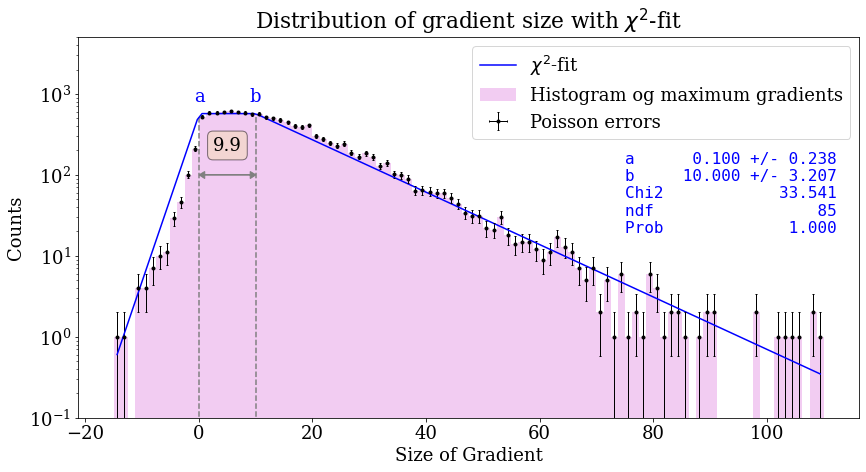

In [66]:
a = minuit_log.values['a']
sigma_a = minuit_log.errors['a']

b = minuit_log.values['b']
sigma_b = minuit_log.errors['b']

val_a = y[np.where(np.isclose(a, x, atol=0.6))[0][0]]
val_b = y[np.where(np.isclose(b, x, atol=0.8))[0][0]]

fig, ax = plt.subplots(figsize=(14,7))

axis = np.linspace(x[0], x[-1], 150)
ax.plot(axis, np.exp([boundary_fit(i, *minuit_log.values[:]) for i in axis]), color='blue', label=f'$\chi^2$-fit')


ax.hist(max_gradients, bins=100, range=(-15, 110), histtype='stepfilled', alpha=0.2, linewidth=2, 
        color='m', label='Histogram og maximum gradients')


ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Poisson errors', 
            fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax.vlines(a, 0, val_a, linestyle='dashed', color='grey')
ax.vlines(b, 0, val_b, linestyle='dashed', color='grey')

ax.arrow(0.15, 100, b-a, 0, head_width=20, head_length=1, linewidth=1, color='grey', length_includes_head=True)
ax.arrow(0.15, 100, -a, 0, head_width=20, head_length=1, linewidth=1, color='grey', length_includes_head=True)

props = dict(boxstyle='round', facecolor='wheat', edgecolor='k', alpha=0.5)
ax.text(2.5, 200, f'{b-a:0.1f}', bbox=props)
ax.text(a-1, 800, f'a', color='b')
ax.text(b-1, 800, f'b', color='b')

ax.set(yscale='log', 
       ylim=(0.1, 5000), 
       xlabel='Size of Gradient', 
       ylabel='Counts', 
       title=f'Distribution of gradient size with $\chi^2$-fit')

# Adding fit results to plot:
d = {'a':       [minuit_log.values['a'], minuit_log.errors['a']],
     'b':       [minuit_log.values['b'], minuit_log.errors['b']],
     'Chi2':     minuit_log.fval,
     'ndf':      len(x) - minuit_log.nfit,
     'Prob':     stats.chi2.sf(minuit_log.fval, len(x) - minuit_log.nfit),
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.7, 0.7, text, ax, fontsize=16, color='blue')

ax.legend()

if save_plots: 
    plt.savefig(r'Graphs/FitBySegments.png');

In [67]:
# Fastsæt hældninger, så den kun skal fitte grænser. Hældningerne kommer af rangen. 
# Liste med ranges.

minx = np.linspace(-15, -10, 10)
maxx = np.linspace(108, 112, 10)
maxy = np.linspace(6, 7, 10)

Chi2_log1 = [] 
FitVals = []
FitErrs = []
Ranges = []

for i in minx: 
    for j in maxx: 
        for k in maxy: 
            
            def boundary_fit1(x, a, b, p0): 
                if x < a: 
                    return k / (a - i) * x + p0
    
                elif a <= x < b: 
                    return k / (a - i) * a + p0
    
                else: 
                    return k / (a - i) * a + p0 + k / (b - j) * (x - b)

            fit_obj_log1 = Chi2Regression(boundary_fit1, x, np.log(y), np.log(sy+1))

            minuit_log1 = Minuit(fit_obj_log1, a=1, b=12, p0=7) 
            minuit_log1.limits['b'] = (7, 15)
            minuit_log1.errordef = 1.0     
            minuit_log1.migrad()
            
            Chi2_log1.append(minuit_log1.fval)
            FitVals.append(minuit_log1.values[:])
            FitErrs.append(minuit_log1.errors[:])
            Ranges.append([i, j, k])

In [76]:
BestFitVals = FitVals[np.argmin(Chi2_fitlog)]
BestFitErrs = FitErrs[np.argmin(Chi2_fitlog)]
minx, maxx, maxy = Ranges[np.argmin(Chi2_fitlog)]
print(f'The minimal Chi2: {np.min(Chi2_fitlog):2.2f}')

The minimal Chi2: 28.07


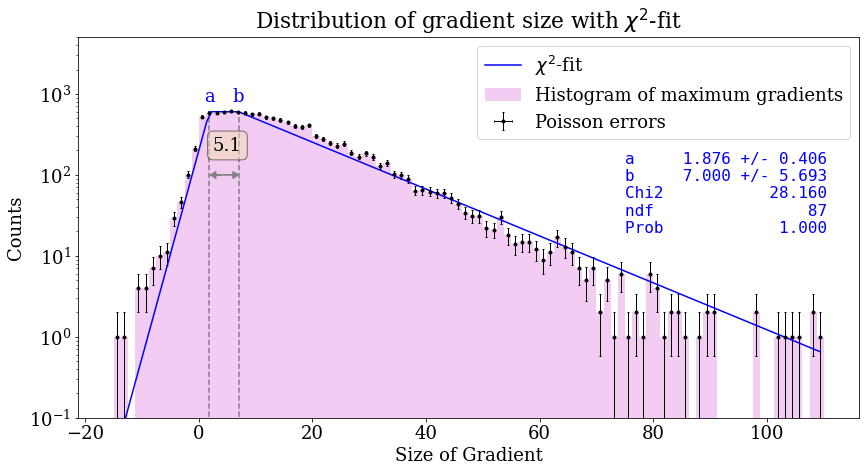

In [88]:
fig, ax = plt.subplots(figsize=(14,7))

axis = np.linspace(x[0], x[-1], 150)
ax.plot(axis, np.exp([boundary_fit1(i, *BestFitVals[:]) for i in axis]), color='blue', label=f'$\chi^2$-fit')


ax.hist(max_gradients, bins=100, range=(-15, 110), histtype='stepfilled', alpha=0.2, linewidth=2, 
        color='m', label='Histogram of maximum gradients')

ax.set(yscale='log', 
       ylim=(0.1, 5000), 
       xlabel='Size of Gradient', 
       ylabel='Counts', 
       title=f'Distribution of gradient size with $\chi^2$-fit')

ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Poisson errors', 
            fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

val_a1 = y[np.where(np.isclose(BestFitVals[0], x, atol=0.6))[0][0]]
val_b1 = y[np.where(np.isclose(BestFitVals[1], x, atol=0.8))[0][0]]

ax.vlines(BestFitVals[0], 0, val_a1, linestyle='dashed', color='grey')
ax.vlines(BestFitVals[1], 0, val_b1, linestyle='dashed', color='grey')

ax.arrow(BestFitVals[0], 100, BestFitVals[1]-BestFitVals[0], 0, head_width=20, head_length=1, linewidth=1, color='grey', length_includes_head=True)
ax.arrow(3.9, 100, -BestFitVals[0], 0, head_width=20, head_length=1, linewidth=1, color='grey', length_includes_head=True)

props = dict(boxstyle='round', facecolor='wheat', edgecolor='k', alpha=0.5)
ax.text(2.5, 200, f'{BestFitVals[1]-BestFitVals[0]:0.1f}', bbox=props)
ax.text(BestFitVals[0]-1, 800, f'a', color='b')
ax.text(BestFitVals[1]-1, 800, f'b', color='b')

ax.set(yscale='log', 
       ylim=(0.1, 5000), 
       xlabel='Size of Gradient', 
       ylabel='Counts', 
       title=f'Distribution of gradient size with $\chi^2$-fit')

# Adding fit results to plot:
d = {'a':       [BestFitVals[0], BestFitErrs[0]],
     'b':       [BestFitVals[1], BestFitErrs[1]],
     'Chi2':     np.min(Chi2_log1),
     'ndf':      len(x) - 3,
     'Prob':     stats.chi2.sf(np.min(Chi2_log1), len(x) - 3),
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.7, 0.7, text, ax, fontsize=16, color='blue')

ax.legend()

if save_plots: 
    plt.savefig(r'Graphs/FitBySegments1.png');

In [89]:
# Comparing the straight part of the distribution from fitting slopes with the average fluctuation of mdm2 when : 

ab_diff = b - a 
sigma_ab_diff = np.sqrt(sigma_a**2 + sigma_b**2)

z_score_diffab = two_sided_z(ab_diff, avefluct_m, sigma_ab_diff, sigma_avefluct_m)

print(f'Difference between average fluctuation and b-a: \
      {ab_diff - avefluct_m:.3f} +/- {np.sqrt(sigma_ab_diff**2 + sigma_avefluct_m**2):.3f}')

print('The biggest contribution to the error on the difference comes from b')

z-score: 0.171 sigma with probability: 0.8638334551
Difference between average fluctuation and b-a:       0.558 +/- 3.255
The biggest contribution to the error on the difference comes from b


In [90]:
# Calculations for the skips: 

all_skip_times = []           # All areas around the slips. Len 401 
all_skip_areas_p = []           
all_skip_areas_m = []

trace_with_no_skips = []      # Index for trace without skip 

for i in range(len(resi_p)):
    
    if len(mdm2_slips[i]) == 0: 
        trace_with_no_skips.append(i)
        continue 
        
    else: 
        analysis = analyze_slips(resi_p[i], roll_resi_m[i], all_local_min_p[i], mdm2_slips[i])
        all_skip_times.append(analysis[0])
        all_skip_areas_p.append(analysis[1])
        all_skip_areas_m.append(analysis[2])                   

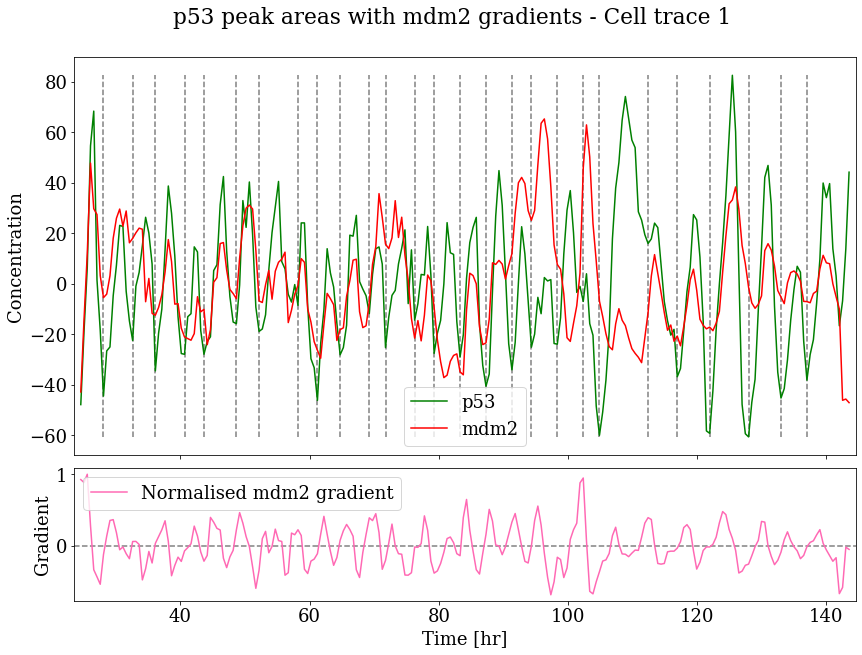

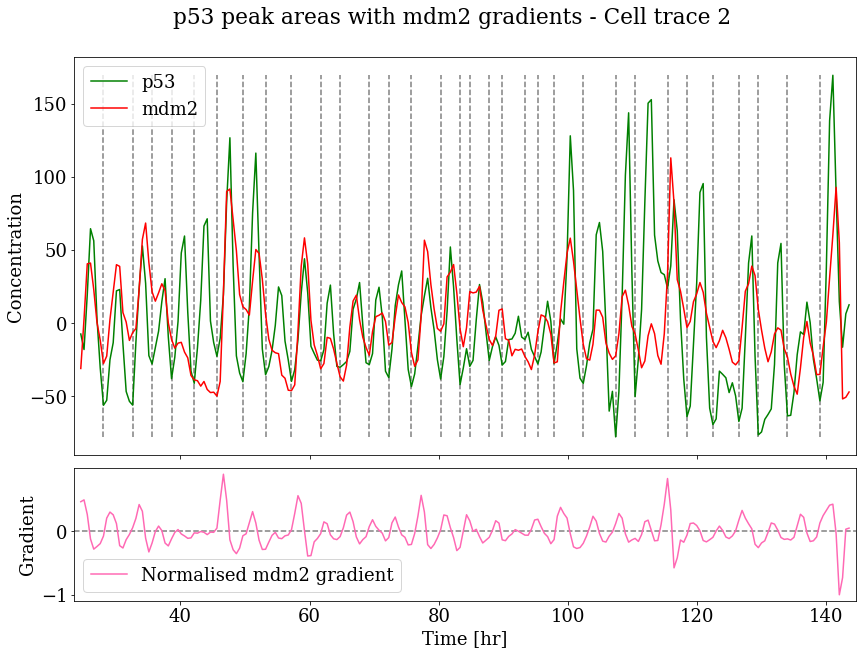

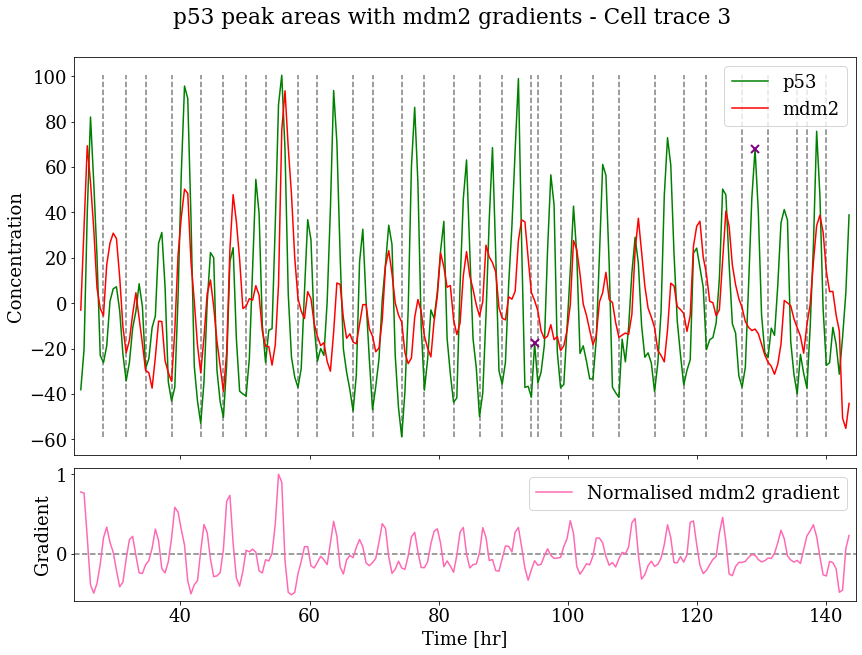

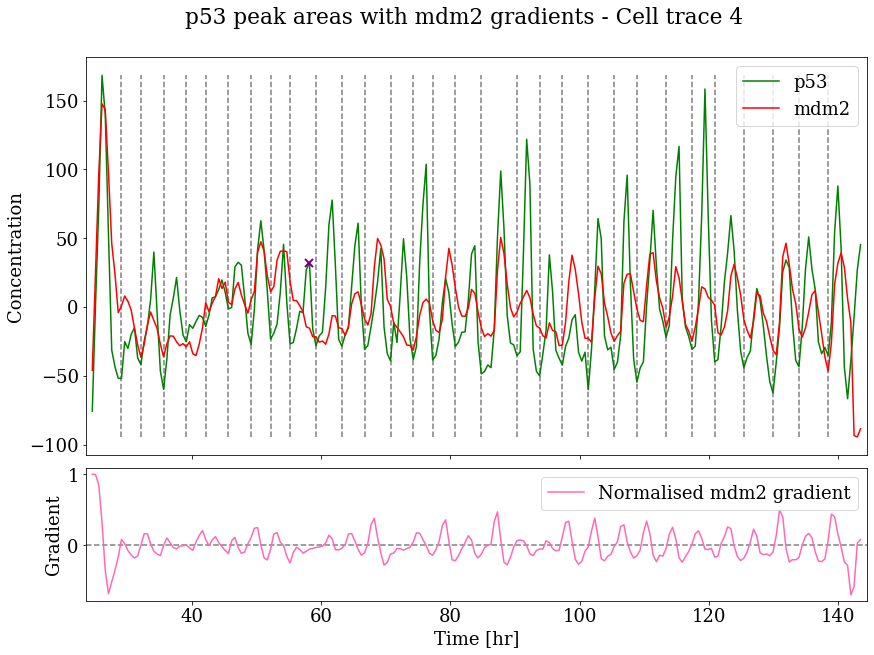

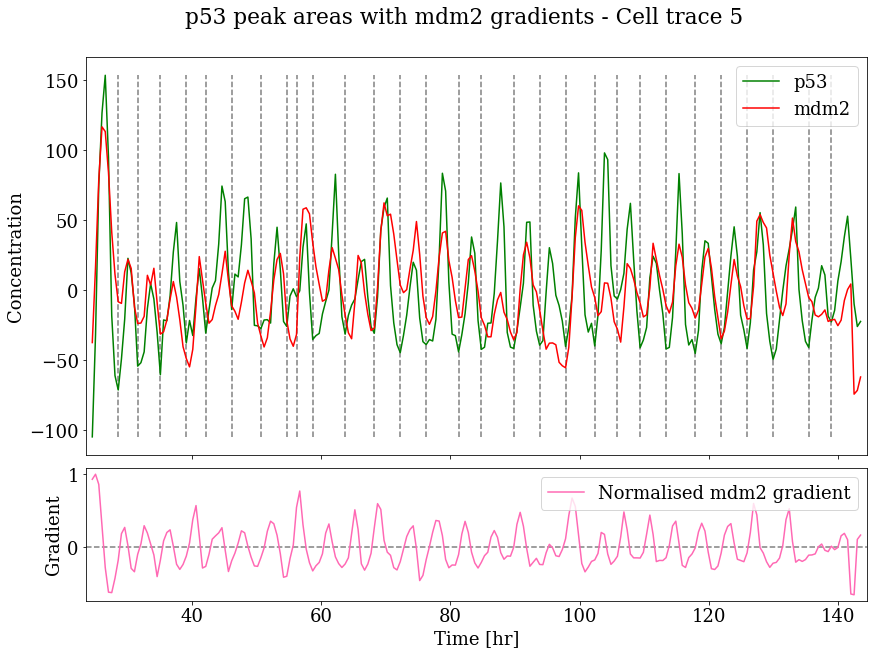

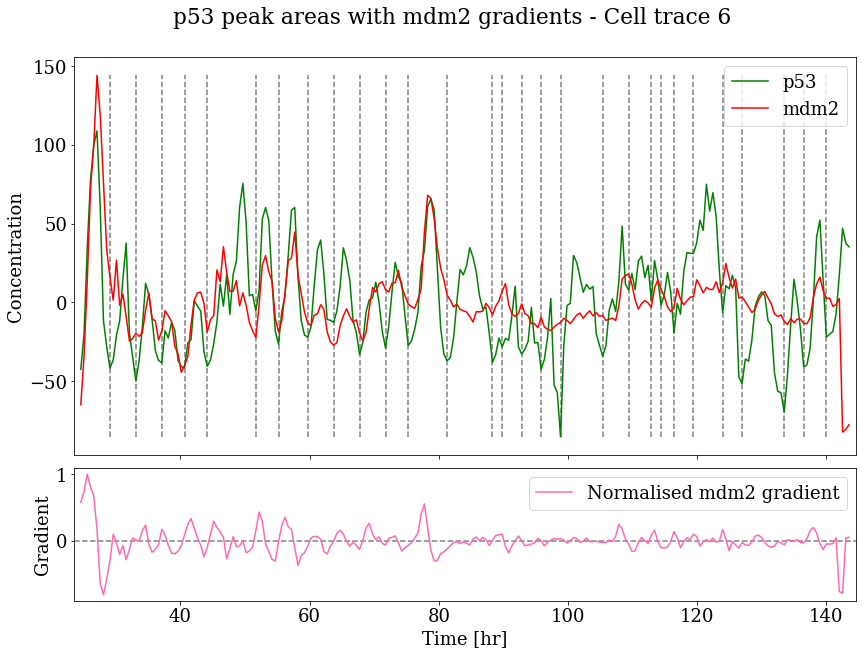

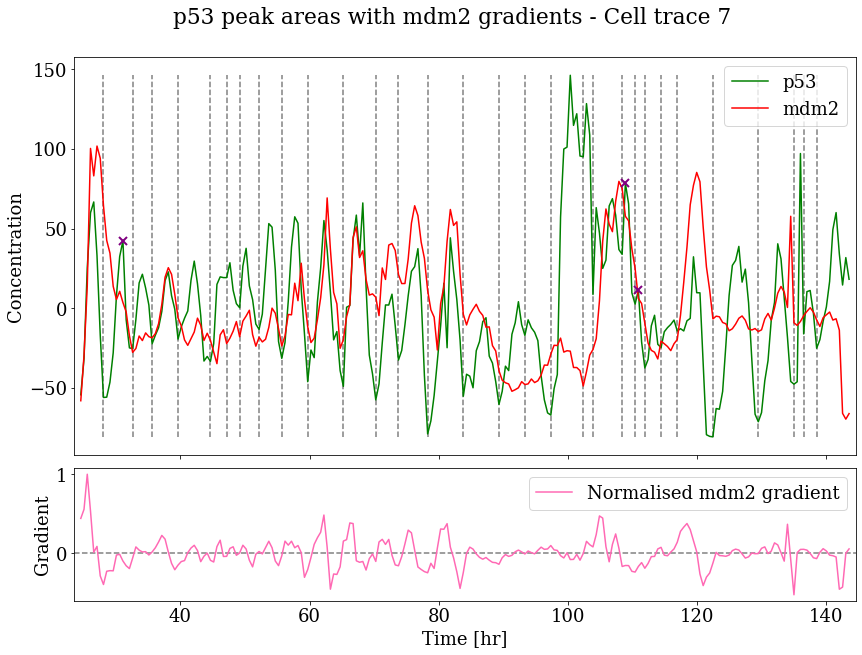

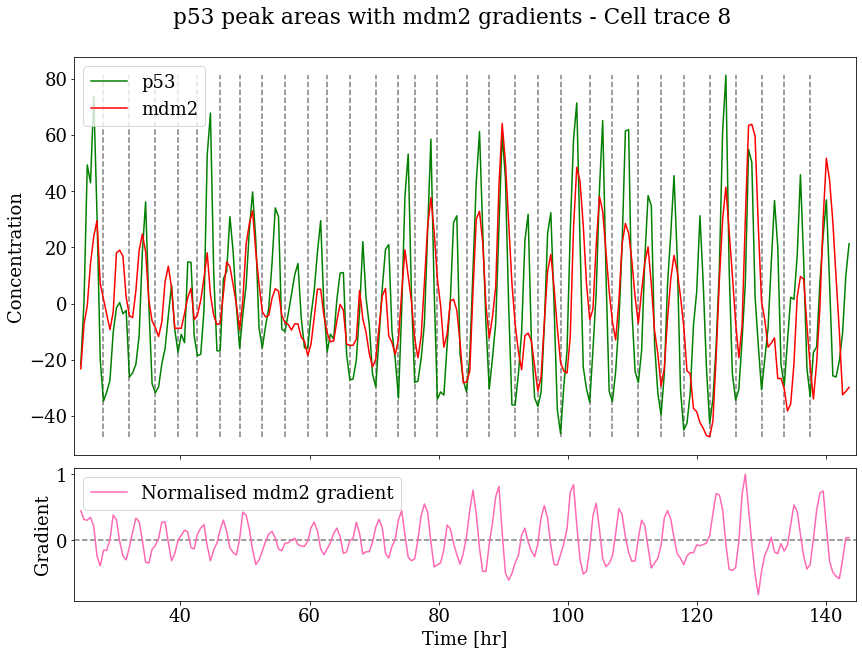

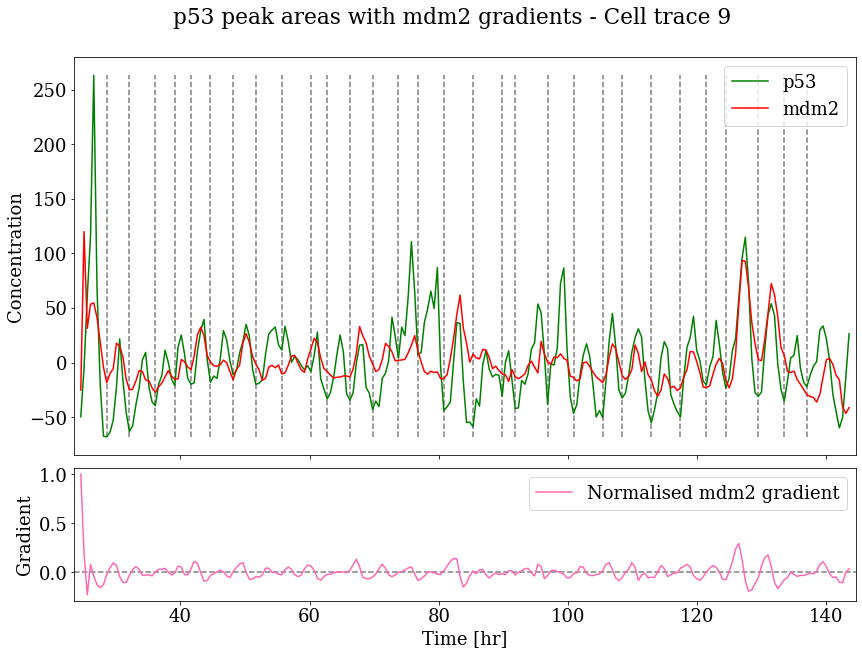

In [91]:
# Plotting traces and gradients for different cells: 

plot = True

if plot:

    for i in range(1, 10):

        fig, axs = plt.subplots(2, 1, figsize=(14,10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        suptitle = fig.suptitle(f'p53 peak areas with mdm2 gradients - Cell trace {i}', y=0.95)

        axs[0].plot(t, resi_p[i], color='green', label='p53')
        axs[0].plot(t, roll_resi_m[i], color='red', label='mdm2')
        
        for j in all_skips[i]:
            axs[0].plot(t[all_peaks_p[i][j]], resi_p[i][all_peaks_p[i][j]], 'x', ms=8, mew=2, color='purple')
        
        axs[0].set(ylabel='Concentration', 
                   xlim=(t[0]-1, t[-1]+1))
        axs[0].legend()

        local_min_p_idx = get_min_idx(resi_p[i], all_local_min_p[i])

        for j in local_min_p_idx: 
            axs[0].vlines(t[j], min([min(resi_p[i]), min(resi_m[i])]), 
                      max([max(resi_p[i]), max(resi_m[i])]), linestyle='dashed', color='grey')

        # Plotting the gradients: 

        axs[1].plot(t, all_gradients[i], color='hotpink', label='Normalised mdm2 gradient')
        axs[1].hlines(0, t[0]-1, t[-1]+1, linestyle='dashed', color='grey')
        axs[1].set(xlabel='Time [hr]', 
               ylabel='Gradient')
        axs[1].legend()

        fig.subplots_adjust(hspace=0.05)

In [ ]:
# Plotting skips in different traces: 

plot = True 

if plot: 
    i = 0 
    while i < 14:
        if len(all_skips[i]) != 0:
            area_idx = all_skips[i][0]


            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

            axs[0].plot(all_peak_times[i][area_idx], all_peak_areas_p[i][area_idx], color='green', label='p53 data')
            axs[0].plot(all_peak_times[i][area_idx], all_peak_areas_m[i][area_idx], color='red', label='mdm2 data')

            axs[0].set(ylabel='Concentration', 
                    title=f'Mdm2 gradient in peak area - Cell trace {i}',
                    xlim=(all_peak_times[i][area_idx][0]-0.1, all_peak_times[i][area_idx][-1]+0.1))

            axs[0].legend()


            axs[1].plot(all_peak_times[i][area_idx], all_peak_areas_grad[i][area_idx], color='hotpink', label='Normalised gradient')
            axs[1].set(xlabel='Time [hr]',
                        ylabel='Mdm2 gradient',
                        ylim=(-1, 1))

            axs[1].hlines(0, 20, 150, linestyle='dashed', color='grey')
            axs[1].legend()

            fig.subplots_adjust(hspace=0.05)

        i +=1

In [ ]:
# Counting the number of traces, where no possible skips are found with gradient method: 

no_skips = 0
number_skips = 0

for i in all_skips:
    if len(i) == 0: 
        no_skips += 1
    else: 
        number_skips += len(i)

print('Gradient Method:')
print(f'Number of traces with no skips: {no_skips}')
print(f'Number of skips: {number_skips}')
print(f'Average number of skips in trace: {number_skips/len(all_skips):1.2}')

count_slips = 0 

for i in mdm2_slips: 
    count_slips += len(i)

print('\nComparing Peak method:')
print(f'Number of skips: {count_slips} (Without filtering for extra peaks in mdm2)')

In [ ]:
def skip_compare(all_skips, mdm2_slips, peak_areas_p, data_p):
    '''Compares array of indices for mdm2 skips from comparison of peak arrays
       with array of indices for skip arrays from gradient method. '''
    
    if len(mdm2_slips) == 0: 
        return None
    
    found_in_both = [] 
    
    for i in all_skips:
        start_idx = np.where(peak_areas_p[i][0] == data_p)[0][0]
        idx_skip_areas = np.arange(start_idx, start_idx + len(peak_areas_p[i]), 1)
        compare = [np.where(mdm2_slips == j)[0] for j in idx_skip_areas]
    
        for j in range(len(compare)): 
            try:
                found_in_both.append(mdm2_slips[compare[j][0]])
            except: 
                j+=1
                
    return found_in_both

In [ ]:
# Compare these to the skips found by own function: 
# Maybe don't use areas that have too few data points

found_in_both = []   # Length 402 

for i in range(len(mdm2_slips)): 
    found_in_both.append(skip_compare(all_skips[i], mdm2_slips[i], all_peak_areas_p[i], resi_p[i]))

    
# Counting the number of skips found in both: 

count_in_both = 0 

for i in found_in_both:
    if not i == None: 
        count_in_both += len(i)

print(f'The number of slips found when comparing the two methods: {count_in_both}')

In [ ]:
# Using the peak finder to check for smaller mdm2 peaks in p53 peak areas: 

peaks_in_slips = []       # List with mdm2 peaks in skip areas. Len 401
local_mdm2_min = []       # And their local minima values 

mdm2_skips_clean = []     # Same list as mdm2_slips, but filtered for the smaller peaks

skip_times_clean = []     # Len 401 
skip_areas_p_clean = []
skip_areas_m_clean = []

for i in range(len(all_skip_areas_m)):
    
    in_slips = [] 
    min_in_slips = []
    
    times = []
    areas_p = []
    areas_m = []
    
    if i >= trace_with_no_skips[0]:  # To avoid the single trace without a skip 
        resi_idx = i + 1
    else:
        resi_idx = i 
        
    
    for j in range(len(all_skip_areas_m[i])): 
        
        # First checking for peaks. Returns index of skip_areas where a peak/peaks is detected: 
        small_peak = peak_finder(all_skip_areas_m[i][j], 'high', avefluct_m)[0]   

        
        # If the function do not find a peak, then the areas will be appended: 
        if len(small_peak) == 0:
            times.append(all_skip_times[i][j])
            areas_p.append(all_skip_areas_p[i][j])
            areas_m.append(all_skip_areas_m[i][j])

            
        # If the function finds more than one peak, the biggest will be appended:
        elif len(small_peak) > 1:  
            # Finding the index in the residual mdm2 trace with the peak value: 
            biggest_peak = np.where(roll_resi_m[resi_idx] == np.max(all_skip_areas_m[i][j][small_peak]))[0][0]
            in_slips.append(biggest_peak)
            
            end_idx = np.where(np.max(all_skip_areas_m[i][j][small_peak]) == all_skip_areas_m[i][j])[0][0]
            min_in_slips.append(np.min(all_skip_areas_m[i][j][:end_idx]))
        
        # If a single peak is found, the index of the mdm2 residual trace will be appended: 
        else: 
            in_slips.append(np.where(roll_resi_m[resi_idx] == all_skip_areas_m[i][j][small_peak])[0][0])      
            min_in_slips.append(np.min(all_skip_areas_m[i][j][:small_peak[0]])) # Taking the minimum before 
    
    # Appending in the i-loop, so the final arrays will have len 401: 
    peaks_in_slips.append(in_slips)      
    local_mdm2_min.append(min_in_slips)
    
    skip_times_clean.append(times)
    skip_areas_p_clean.append(areas_p)
    skip_areas_m_clean.append(areas_m)
    
    mdm2_skips_clean.append(compare_peaks(all_peaks_p[resi_idx], 
                                          np.sort(all_peaks_m[resi_idx] + peaks_in_slips[i]), 
                                          all_local_min_p[resi_idx])[1])
    

In [ ]:
# Counting the number of mdm2 peaks found the initial skip areas: 

count_peaks_in_slips = 0 

for i in peaks_in_slips:
    count_peaks_in_slips += len(i)

count_peaks_in_slips

print(f'Skips found by comparing arrays of peaks: {count_slips}')           # Len of arrays in mdm2 slips
print(f'Mdm2 peaks found i possible skip areas: {count_peaks_in_slips}')    # Len of arrays in peaks_in_slips 
print(f'Number of possible skips: {count_slips-count_peaks_in_slips}')

In [ ]:
# Counting the number of mdm2 skips after 
count_clean_mdm2_skips = 0 

for i in mdm2_skips_clean: 
    count_clean_mdm2_skips += len(i)

print(f'Number of possible skips: {count_clean_mdm2_skips}')
print("The reason why this count and the one above for possible skips don't agree, is that...")

In [ ]:
# Using the array with cleaned mdm2 skip areas to search for mutual skips of the two methods: 

found_in_both_clean = []

for i in range(len(mdm2_skips_clean)): 
    found_in_both_clean.append(skip_compare(all_skips[i], mdm2_skips_clean[i], all_peak_areas_p[i], resi_p[i]))

    
# Counting the number of skips found in both: 

count_in_both_clean = 0 

for i in found_in_both_clean:
    if not i == None:
        count_in_both_clean += len(i)

print(f'The number of slips found when comparing the two methods: {count_in_both_clean}')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7), gridspec_kw={'width_ratios': [5, 3]})

idx = r.choice(np.arange(0, 401, 1))

while len(found_in_both_clean[idx]) == 0: 
    idx = r.choice(np.arange(0, 401, 1))

else:
    peak_plotter(t, resi_p[idx], found_in_both_clean[idx], ax[0], 'p53')
    ax[0].plot(t, roll_resi_m[idx], color='red', label='mdm2')
    ax[1].plot(skip_times_clean[idx][0], skip_areas_m_clean[idx][0], color='red')
    ax[1].plot(skip_times_clean[idx][0], skip_areas_p_clean[idx][0], color='green')
    ax[1].plot(t[found_in_both_clean[idx][0]], resi_p[0][found_in_both_clean[idx][0]], 'x')

ax[0].legend()